## Visualizing Linear Regression:

Contributors: Matt Winkler and Drew Malter  
July 2018

### Goal:

This analysis explores visualizations of regression, whose aim is to provide an intuitive understanding of how well they fit the data and how they function under-the-hood.

### Data:

The data used for this analysis originally came from a Kaggle competition sponsored by Allstate. https://www.kaggle.com/c/allstate-purchase-prediction-challenge/data. In this analysis, we drop the categorical variables and focus on predicting the quoted policy cost based on the rest of the data.

### Background:

Regressions are a supervised learning method used for predicting continuous numeric variables. Linear regressions answer _how much_ a target varible is impacted by one or several predictor variables. For example: _How much_ does the cost of car insurance change based on location, age, car age, etc?  To do this, they essentially solve for m in the familiar y = mx + b.

### Summary:

* Supervised learning with continuous variable
* _How much?_
* think y = mx + b

### Why spend time visualizing regressions?

##### 1: They're important!

Regressions are the most common way for assessing whether  

* there's a relationship between two things and  
* how strong the relationship is.  

While they're one of the oldest forms of machine learning, they're still highly relevant in economics, healthcare, and insurance among other domains. 

##### 2: The way Data Scientists typically display regression results isn't very helpful :(

While regression output tables are useful interpretation tools for experienced statisticians, they're awful from a visualization standpoint. When interpreting a regression, there are several things people want to know:

* Which predictor variables have significant effects on the target variable?  
* How strong are those effects?  
* How accurately can we predict the target variable?

In [224]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings

from ipywidgets import interact, interact_manual, widgets, Layout

from bokeh.io import push_notebook, show, output_notebook, curdoc
from bokeh.plotting import figure
from bokeh.models.annotations import Title
from bokeh.models.widgets import MultiSelect
from bokeh.models import Button
from bokeh.layouts import widgetbox, column, row

from sklearn.model_selection import train_test_split
from sklearn import linear_model

%matplotlib inline
warnings.filterwarnings('ignore')

In [225]:
# load dataset:
df = pd.read_csv('data/CarInsurance_Claims.csv')

# preview of the data:
df.head()

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,10000000,1,0,0,8:35,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,2,633
1,10000000,2,0,0,8:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
2,10000000,3,0,0,8:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
3,10000000,4,0,0,8:39,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
4,10000000,5,0,0,11:55,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630


In [226]:
# number of observations x number of features:
df.shape

(665249, 25)

In [227]:
# datatypes for each column:
df.dtypes

customer_ID            int64
shopping_pt            int64
record_type            int64
day                    int64
time                  object
state                 object
location               int64
group_size             int64
homeowner              int64
car_age                int64
car_value             object
risk_factor          float64
age_oldest             int64
age_youngest           int64
married_couple         int64
C_previous           float64
duration_previous    float64
A                      int64
B                      int64
C                      int64
D                      int64
E                      int64
F                      int64
G                      int64
cost                   int64
dtype: object

We are going to drop the A-G columns for this exercise, since they're categorical dependent variables which don't have a relationship with the rest of the predictor variables or the cost.  We'll also remove customer_ID to avoid overfitting the predictions to individual customers.

In [228]:
df.drop(columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'customer_ID'], 
        axis = 1, 
       inplace=True)

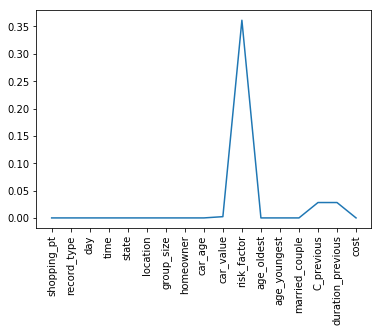

In [229]:
# percentage of missing values by column:
nulls = df.isnull().sum() / df.shape[0]
labels = nulls.index
_ = plt.plot(nulls)
_ = plt.xticks(rotation='vertical')

There are a relatively high number of nulls in the risk_factor column at over 35%. C_previous and duration_previous are also missing some values.  We could fill in the missing values with a number of methods (mean, median, separate classification / regression models).  We are fortunate to have a lot of data in this set, so will drop the records with missing values.

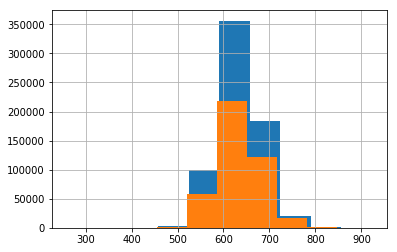

In [230]:
df2 = df.dropna()

# check shape of distributions with and without NAs
df['cost'].hist()
df2['cost'].hist()

In [231]:
df.describe()

,shopping_pt,record_type,day,location,group_size,homeowner,car_age,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,cost
count,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,424831.000000,665249.000000,665249.000000,665249.000000,646538.000000,646538.000000,665249.000000
mean,4.219966,0.145824,1.969429,12271.543022,1.234784,0.536229,8.139437,2.563996,44.992403,42.577588,0.209782,2.444718,6.003774,635.785008
std,2.394369,0.352930,1.453470,1564.789415,0.461036,0.498686,5.764598,1.111584,17.403440,17.460432,0.407153,1.034596,4.680793,45.993758
min,1.000000,0.000000,0.000000,10001.000000,1.000000,0.000000,0.000000,1.000000,18.000000,16.000000,0.000000,1.000000,0.000000,260.000000
25%,2.000000,0.000000,1.000000,10936.000000,1.000000,0.000000,3.000000,2.000000,28.000000,26.000000,0.000000,1.000000,2.000000,605.000000
50%,4.000000,0.000000,2.000000,12027.000000,1.000000,1.000000,7.000000,3.000000,44.000000,40.000000,0.000000,3.000000,5.000000,635.000000
75%,6.000000,0.000000,3.000000,13426.000000,1.000000,1.000000,12.000000,4.000000,60.000000,57.000000,0.000000,3.000000,9.000000,665.000000
max,13.000000,1.000000,6.000000,16580.000000,4.000000,1.000000,85.000000,4.000000,75.000000,75.000000,1.000000,4.000000,15.000000,922.000000


In [232]:
df2.describe()

,shopping_pt,record_type,day,location,group_size,homeowner,car_age,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,cost
count,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000
mean,4.267471,0.149133,1.948587,12275.645248,1.249184,0.594186,7.717696,2.559003,48.032181,45.544067,0.226383,2.596406,6.679780,632.695010
std,2.397240,0.356220,1.452714,1552.833289,0.470781,0.491050,5.637517,1.112997,17.878804,18.144699,0.418490,1.007123,4.825717,46.219299
min,1.000000,0.000000,0.000000,10001.000000,1.000000,0.000000,0.000000,1.000000,18.000000,16.000000,0.000000,1.000000,0.000000,260.000000
25%,2.000000,0.000000,1.000000,10965.000000,1.000000,0.000000,3.000000,2.000000,31.000000,28.000000,0.000000,2.000000,3.000000,601.000000
50%,4.000000,0.000000,2.000000,12037.000000,1.000000,1.000000,7.000000,3.000000,49.000000,45.000000,0.000000,3.000000,6.000000,631.000000
75%,6.000000,0.000000,3.000000,13427.000000,1.000000,1.000000,11.000000,4.000000,64.000000,62.000000,0.000000,3.000000,10.000000,662.000000
max,13.000000,1.000000,6.000000,16580.000000,4.000000,1.000000,85.000000,4.000000,75.000000,75.000000,1.000000,4.000000,15.000000,911.000000


There are a couple of things to note from the output above. One, we didn't change the variable distributions too much by removing records with missing values. If we had, we'd risk affecting the coefficient estimates produced by the regression.

By comparing the mean and median values, we can also see that several variables have skewed distributions, since the mean and median are far apart.  There are a couple remaining steps for our data prep: 

1) The above only looks at the numeric features in the data. We should also look at the categoricals to determine whether they have any potential value.

2) Regression is sensitive to outliers in the data, so we want to evaluate and address variable skew before proceeding further.


In [233]:
df = df2
del df2

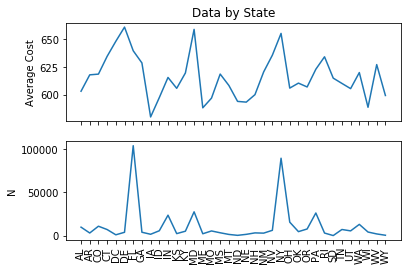

In [234]:
state_cost = df.groupby('state')['cost'].mean()
state_count = df.groupby('state').size()

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
_ = ax1.plot(state_cost)
_ = ax1.set_ylabel('Average Cost')
_ = ax1.set_title('Data by State')
_ = ax2.plot(state_count)
_ = ax2.set_ylabel('N')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

There are some states with many more observations than others. Average cost also varies by up to 10% depending on the state. It may be interesting to see if geographic influence is detectable in the regression, so we'll keep the state variable for the moment.

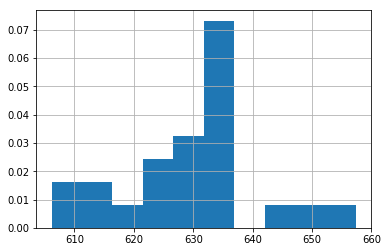

In [235]:
# get the times as a list and round to the hour:
times = df['time'].values.tolist()
df['time'] = [tm.split(':')[0] for tm in times]

times = df.groupby('time')['cost'].mean()

_ = times.hist(density=True)

There isn't much variation of the cost across different values of the time variable. So, let's drop this feature.

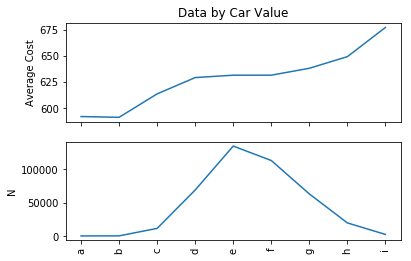

In [236]:
car_cost = df.groupby('car_value')['cost'].mean()
car_counts = df.groupby('car_value').size()

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
_ = ax1.plot(car_cost)
_ = ax1.set_ylabel('Average Cost')
_ = ax1.set_title('Data by Car Value')
_ = ax2.plot(car_counts)
_ = ax2.set_ylabel('N')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

There appears to be a relationship between the car_value feature and the cost. However, there are relatively few observations at the high and low ends of car_value. We can try bucketing values a-c and g-i together.

In [237]:
df.loc[df['car_value'].isin(['a', 'b', 'c']), 'car_value'] = 'a-c'
df.loc[df['car_value'].isin(['g', 'h', 'i']), 'car_value'] = 'g-i'

In [238]:
# remove the time variable as discussed earlier:
df.drop(columns=['time'], axis=1, inplace=True)

In [239]:
# clean up duration_previous, C_previous, and risk_factor columns since they should be ints
df['duration_previous'] = df['duration_previous'].astype(int)
df['C_previous'] = df['C_previous'].astype(int)
df['risk_factor'] = df['risk_factor'].astype(int)

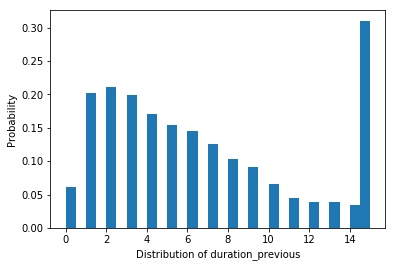

In [240]:
# Example plotting a single variable to evaluate its skew:
feature = 'duration_previous'
plt.hist(df[feature], density=True, bins=30)
plt.ylabel('Probability')
plt.xlabel('Distribution of {}'.format(feature));

What if we had a dataset with 1,000 (or 10,000) variables and wanted to evaluate the skew for each? We'd need a lot of code! Or, we can use a more interactive approach to look at each variable in turn with the Bokeh library.

In [241]:
# plot setup:
p = figure(title="Test", 
           background_fill_color="#E8DDCB", 
           width=500, 
           height=300)

# get values and make histogram:
arr = df['car_age'].values
hist, edges = np.histogram(arr, 
                           density=True, 
                           bins=50)

# assign histogram to the figure:
r = p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")

show(p)

# update() function to make the plot interactive:
def update(feature, num_bins):
    # update array and histogram values:
    arr = df[feature].values
    hist, edges = np.histogram(arr, 
                           density=True, 
                           bins=num_bins)
    
    # update plot parameters:
    p.title.text = 'Probability distribution of {}'.format(feature)
    p.xaxis.axis_label = '{}'.format(feature)
    p.yaxis.axis_label = 'Pr({})'.format(feature)
    
    # reset the renderer data:
    r.data_source.data['top'] = hist
    r.data_source.data['left'] = edges[:-1]
    r.data_source.data['right'] = edges[1:]
    
    push_notebook()

output_notebook()

Loading BokehJS ...

In [242]:
features = [f for f in df.columns.values if f not in \
            ['car_value', 'state', 'location']]
nbins = (5, 50)
interact(update, feature = features, num_bins = nbins)
show(p, notebook_handle = True)

interactive(children=(Dropdown(description='feature', options=('shopping_pt', 'record_type', 'day', 'group_siz…

Now let's look at the boxplots for each feature in the data to check them all for outliers

In [243]:
def min_max(col):
    """Min-max scales input to 0-1 range."""
    mn = min(col)
    mx = max(col)
    scaled = ((col - mn) / (mx - mn))
    return scaled

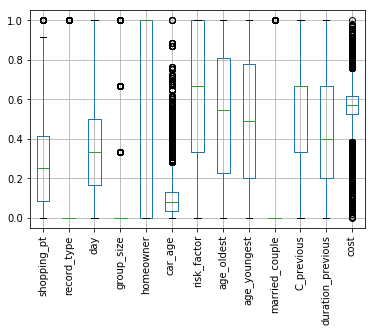

In [244]:
scaled = df[features].apply(min_max)
my_plt = scaled.boxplot(rot=90)

Based on the above, car_age could be capped based on its high skew. Check first whether there is a clear relationship between the two.

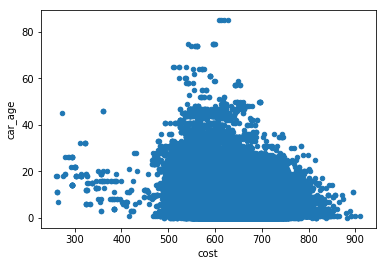

In [245]:
_ = df.plot.scatter('cost', 'car_age')

In [246]:
# define outlier adjustment function:
def adjust_outliers(array_in):
    """ Finds and replaces outliers in input array with 1.5 * IQR"""
    array_out = np.array(array_in)
    
    q1 = array_in.quantile(q=0.25)
    q3 = array_in.quantile(q=0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    
    below_ind = array_out < lower
    above_ind = array_out > upper
    
    array_out[below_ind] = lower
    array_out[above_ind] = upper
    
    changed = np.sum(array_in != array_out)
    print('Found and adjusted {} values in {} column'.format(str(changed), array_in.name))
    return array_out

In [247]:
# adjust outliers in the car_age_feature:
df['car_age'] = adjust_outliers(df['car_age'])

Found and adjusted 4896 values in car_age column


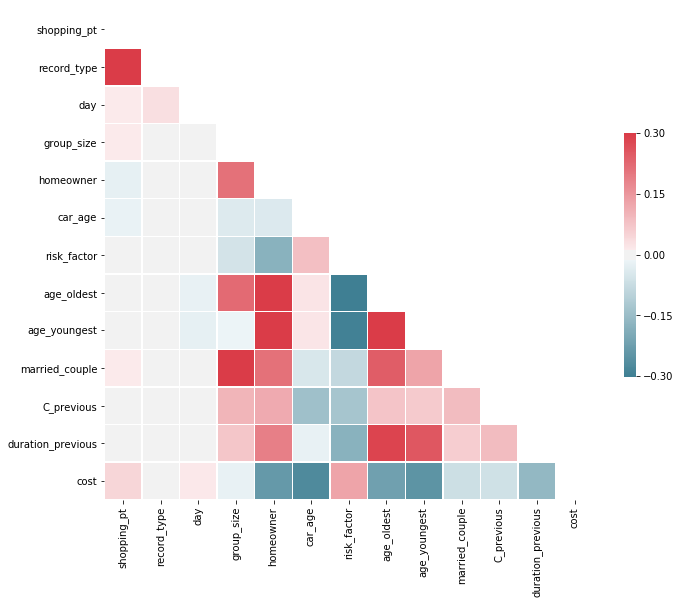

In [248]:
corr = df[features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Overall there don't appear to be strong correlations in the dataset across the intput variables or with the target. age_oldest and age_youngest are an exception, with a correlation of over .9. We should encode some of the features as binary variables since their values don't necessarily represent incremental increases

In [249]:
df.nunique()

shopping_pt            13
record_type             2
day                     7
state                  36
location             5888
group_size              4
homeowner               2
car_age                24
car_value               5
risk_factor             4
age_oldest             58
age_youngest           60
married_couple          2
C_previous              4
duration_previous      16
cost                  472
dtype: int64

In [250]:
# one-hot encoding of categorical columns:
df = pd.get_dummies(df,
                    drop_first=True,
                    columns = ['state', 'group_size', 
                               'risk_factor', 'car_value', 'C_previous'])

In [251]:
# Days 5 and 6 are weekend days, add a flag for them vs. the others
df['weekend'] = df['day'].isin([5, 6]).astype(int)

In [252]:
y = df['cost']
X = df.drop(columns=['cost', 'location', 'shopping_pt', 'age_youngest', 'day'])

In [253]:
lm = linear_model.LinearRegression()

#Split data set into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

#Fit the model :
lm.fit(X_train, y_train)

#Set predictions
lm_train_pred = lm.predict(X_train)
lm_test_pred = lm.predict(X_test)

In [254]:
y_mn_train = np.mean(y_train)
sst_train = sum((y_train - y_mn_train)**2)
ssr_train = sum((lm_train_pred - y_train)**2)
r2_train = 1 - (ssr_train / sst_train)

y_mn_test = np.mean(y_test)
sst_test = sum((y_test - y_mn_test)**2)
ssr_test = sum((lm_test_pred - y_test)**2)
r2_test = 1 - (ssr_test / sst_test)

print('R^2 of the model on training data was: {}'.format(str(r2_train)))
print('R^2 of the model on testing data was: {}'.format(str(r2_test)))

R^2 of the model on training data was: 0.39765364641268
R^2 of the model on testing data was: 0.39841493260917116


In [255]:
#Return the summary of the model
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     5014.
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        19:13:48   Log-Likelihood:            -2.0867e+06
No. Observations:              417447   AIC:                         4.174e+06
Df Residuals:                  417391   BIC:                         4.174e+06
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               622.0543      0.57

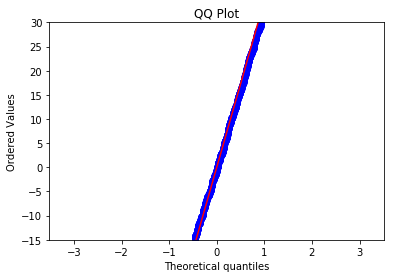

In [256]:
# Check residual distribution:
import pylab 
import scipy.stats as stats

idx = np.random.choice(X_train.index, 1000, replace=False)

x_train_sample = X_train.ix[idx]
y_train_sample = y_train.ix[idx]

#Set predictions
lm.fit(x_train_sample, y_train_sample)
lm_train_pred_sample = lm.predict(x_train_sample)

residuals = y_train_sample - lm_train_pred_sample
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.ylim([-15,30])
pylab.title("QQ Plot")
pylab.show()

The regression residuals don't deviate from a normal distribution, which means there is not systemic bias in the model's predictions.  Now check for interaction terms to see if including them improves the fit.

In [257]:
interactions = list()
baseline = r2_train

checks = ['homeowner', 'married_couple', 'C_previous_2', 'C_previous_3', 'C_previous_4',
          'duration_previous', 'age_oldest', 'car_age', 'risk_factor_2', 'risk_factor_3', 'risk_factor_4', 
         'car_value_d', 'car_value_e', 'car_value_f', 'car_value_g-i', 
         'group_size_2', 'group_size_3', 'group_size_4']

for feature_A in checks:
    for feature_B in checks:
        
        if feature_A > feature_B:
            X_train['interaction'] = X_train[feature_A] * X_train[feature_B]
            
            lm.fit(X_train, y_train)
            lm_train_pred = lm.predict(X_train)
                
            y_mn_train = np.mean(y_train)
            sst_train = sum((y_train - y_mn_train)**2)
            ssr_train = sum((lm_train_pred - y_train)**2)
            r2_train = 1 - (ssr_train / sst_train)
            
            improvement = r2_train - baseline
            
            if r2_train > baseline:
                interactions.append((feature_A, feature_B, round(improvement,3)))

print('Baseline R2: %.3f' % r2_train)
print('Top 10 interactions: %s' % sorted(interactions, key=lambda x: x[2],
 reverse=True)[:10])

Baseline R2: 0.398
Top 10 interactions: [('married_couple', 'group_size_2', 0.01), ('duration_previous', 'age_oldest', 0.006), ('risk_factor_3', 'age_oldest', 0.004), ('homeowner', 'age_oldest', 0.003), ('risk_factor_3', 'duration_previous', 0.002), ('risk_factor_4', 'car_age', 0.002), ('homeowner', 'duration_previous', 0.001), ('married_couple', 'age_oldest', 0.001), ('car_age', 'age_oldest', 0.001), ('risk_factor_2', 'age_oldest', 0.001)]


Some of the interactions tested above are interesting.  For example, married_couple * group_size_2 appears to improve the fit, suggesting that married couples _without_ kids are priced differently from the rest of the sample.

In [258]:
# add top interaction terms from the previous step:
X['married_g2'] = X['married_couple'] * X['group_size_2']
X['duration_age_oldest'] = X['duration_previous'] * X['age_oldest']
X['homeowner_age_oldest'] = X['homeowner'] * X['age_oldest']
X['risk_factor_3_age_oldest'] = X['risk_factor_3'] * X['age_oldest']

In [259]:
# refit model with additional terms:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#Fit the model :
lm.fit(X_train, y_train)

#Set predictions
lm_train_pred = lm.predict(X_train)
lm_test_pred = lm.predict(X_test)

In [260]:
# Check the fit:
y_mn_train = np.mean(y_train)
sst_train = sum((y_train - y_mn_train)**2)
ssr_train = sum((lm_train_pred - y_train)**2)
r2_train = 1 - (ssr_train / sst_train)

y_mn_test = np.mean(y_test)
sst_test = sum((y_test - y_mn_test)**2)
ssr_test = sum((lm_test_pred - y_test)**2)
r2_test = 1 - (ssr_test / sst_test)

print('R^2 of the model on training data was: {}'.format(str(r2_train)))
print('R^2 of the model on testing data was: {}'.format(str(r2_test)))

R^2 of the model on training data was: 0.4183834157837474
R^2 of the model on testing data was: 0.4194415777441063


Including interactions improved the model's fit by about 5%, which is nice! We're still a ways from being able to predict cost with a high degree of accuracy.

## Analyzing regression results (the old way):

There was some effort involved in producing the regression model that we're going to inspect, but we aren't going to worry about those specifics. Instead, let's look at some diagnostic output below. A few items to remember for later:

* R-squared
* Coefficient estimate
* 95% confidence interval

In [261]:
#Return the summary of the model
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     5094.
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        19:18:14   Log-Likelihood:            -2.0794e+06
No. Observations:              417447   AIC:                         4.159e+06
Df Residuals:                  417387   BIC:                         4.160e+06
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      632.6809      0.630   1004.095      0.000     631.446     633.916
record_type                 -0.3620      0.153     -2.363      0.018      -0.662      -0.062
homeowner                  -25.1696      0.345    -73.004      0.000     -25.845     -24.494
car_age                     -2.1261      0.011   -193.688      0.000      -2.148      -2.105
age_oldest                  -0.4421      0.007    -61.615      0.000      -0.456      -0.428
married_couple               6.2018      0.313     19.787      0.000       5.588       6.816
duration_previous           -2.9341      0.040    -72.945      0.000      -3.013      -2.855
state_AR                    12.2638      0.722     16.998      0.000      10.850      13.678
state_CO                    10.9169      0.491     22.252      0.000       9.955      11.878
state_CT                    25.4718      0.549     46.367      0.000      24.395      26.548
state_DC                    35.9814      1.132     31.786      0.000      33.763      38.200
state_DE                    54.7136      0.665     82.296      0.000      53.411      56.017
state_FL                    43.4348      0.378    114.982      0.000      42.694      44.175
state_GA                    22.7448      0.660     34.481      0.000      21.452      24.038
state_IA                   -28.0255      0.927    -30.221      0.000     -29.843     -26.208
state_ID                    -4.0717      0.589     -6.913      0.000      -5.226      -2.917
state_IN                     8.6666      0.426     20.362      0.000       7.832       9.501
state_KS                    -0.2333      0.797     -0.292      0.770      -1.796       1.330
state_KY                    12.7304      0.604     21.076      0.000      11.547      13.914
state_MD                    50.8621      0.418    121.798      0.000      50.044      51.681
state_ME                   -17.1830      0.820    -20.945      0.000     -18.791     -15.575
state_MO                   -11.6170      0.593    -19.578      0.000     -12.780     -10.454
state_MS                    14.1682      0.701     20.216      0.000      12.795      15.542
state_MT                     3.8182      0.974      3.919      0.000       1.909       5.728
state_ND                    -7.2971      1.689     -4.320      0.000     -10.608      -3.987
state_NE                    -9.7554      0.950    -10.270      0.000     -11.617      -7.894
state_NH                    -6.7467      0.712     -9.475      0.000      -8.142      -5.351
state_NM                    15.4797      0.735     21.049      0.000      14.038      16.921
state_NV                    29.7812      0.571     52.181      0.000      28.663      30.900
state_NY                    56.0228      0.381    147.206      0.000      55.277      56.769
state_OH      

![title](images/confused-emoji.png)

### Interpret the regression results (visual way):

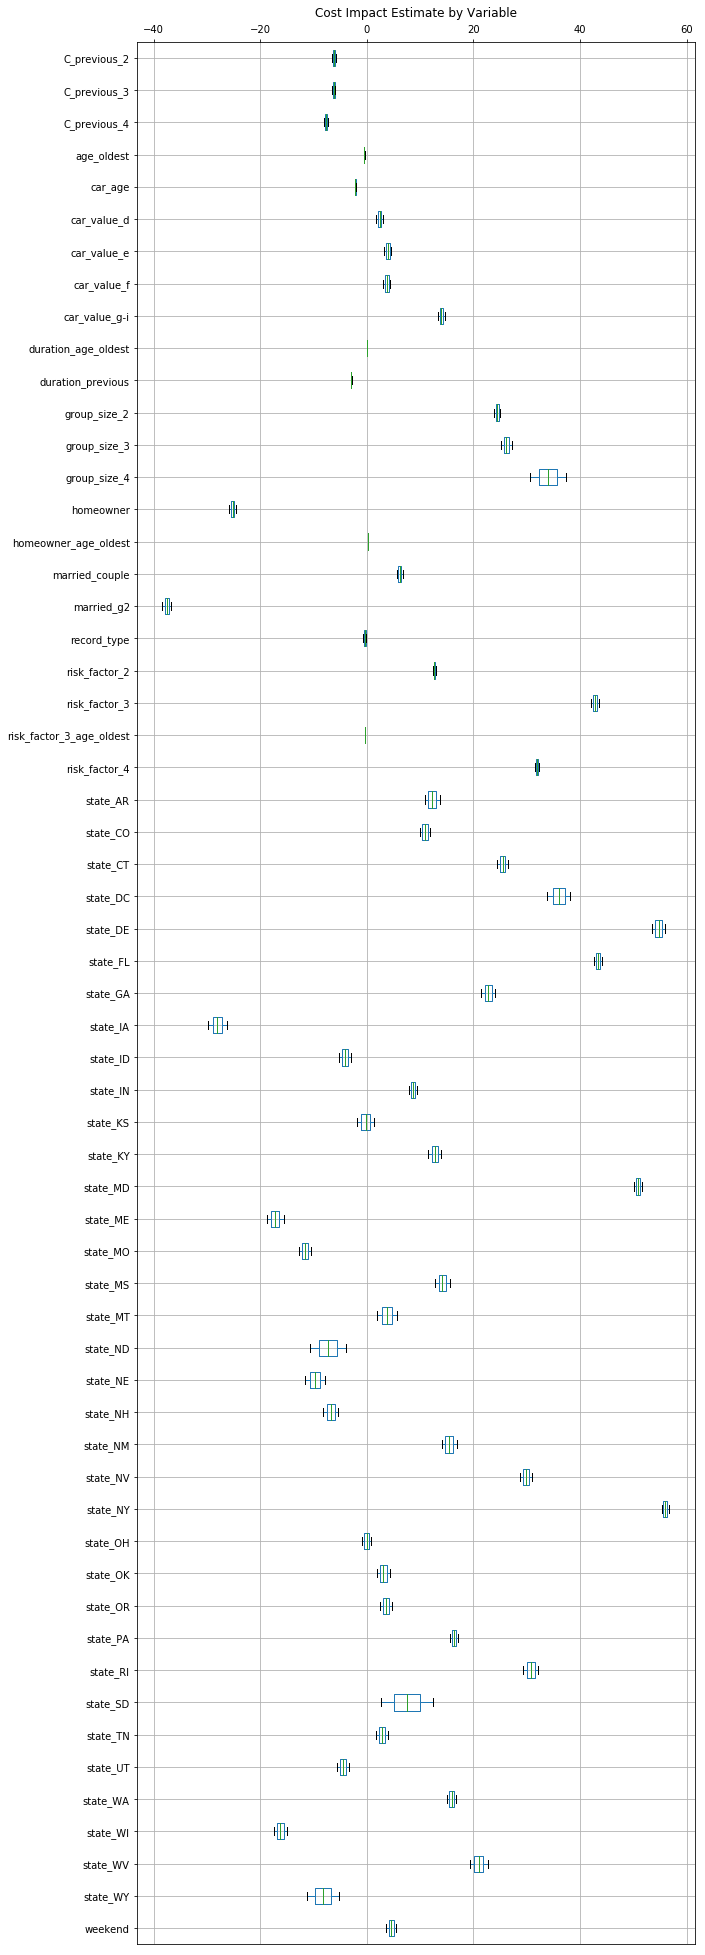

In [262]:
dir(est2)
paramdf = est2.conf_int()
paramdf['estimate'] = est2.params
paramdf.columns = ['lower_95', 'upper_95', 'coef_estimate']
paramdf.sort_index(inplace=True, ascending=False)
paramdf = paramdf.T
paramdf.drop(columns=['const'], axis=1, inplace=True)

_ = plt.figure(figsize=(10, 35))
_ = paramdf.boxplot(vert=False)
_ = plt.axes().xaxis.tick_top()
_ = plt.title('Cost Impact Estimate by Variable', y=1.01)

From looking at the above, we can immediately see which variables have a larger impact on cost as they move further from zero.  

Recall two terms from earlier:

* **Coefficient estimate:** this is the middle of the boxes in the plot
* **95% confidence Interval:** Either end of the same boxes

Variables with confidence intervals that overlap zero are not significant within a 95% confidence level.  

Here are some interesting things to learn from looking at the plot:

* homewowners and married couples tend to pay less for insurance
* Each additional year of car ownership reduces the cost of insurance by 2.07 compared to the average
* Married couples pay more than average for insurance, **but** married couples with only two family members (i.e. no kids) pay much less.
* Cost of insurance varies widely by state.  New York, Maryland, and Delaware show the largest increases, while Midwestern states Iowa, Missouri, and Wisconsin have the largest decreases
* Group_size and risk_factor increase the cost of insurance when present, especially at higher levels
* Cars that are rated with higher values are more expensive to insure

## Regression Mechanics and R^2:

Now, let's develop a better intuition of how the regression operates on each variable. Recall **R^2** from earlier. R^2 measures the accuracy of the regression in terms of how well it describes the variability in the target around its mean. A perfect fit, where every predicted value matches the actual value has an R^2 of 1.0. On the other hand, we could predict the mean for every observation in the dataset, and the R^2 would be 0.0. That's because predicting the mean for every observation wouldn't represent how the data moves _around_ the mean at all.

We'll see what this means visually below.

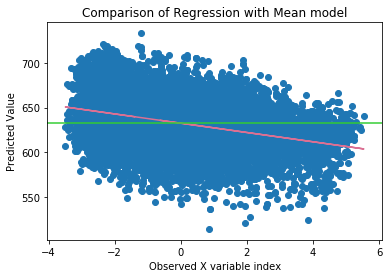

In [263]:
# PCA for plotting and compare predictions to dummy regressor:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor

idx = np.random.choice(X_train.index, 10000, replace=False)

x_train_sample = X_train.ix[idx]
y_train_sample = y_train.ix[idx]

#Set predictions
lm.fit(x_train_sample, y_train_sample)
lm_train_pred_sample = lm.predict(x_train_sample)

regdummy = DummyRegressor(strategy="mean")
regdummy.fit(x_train_sample, y_train_sample)
dummy_y = regdummy.predict(x_train_sample)

scaler = StandardScaler()
X_s = scaler.fit_transform(x_train_sample)

pca = PCA(n_components=1)
pca.fit(X_s)
X_pca = pca.fit_transform(X_s)

m, b = np.polyfit(X_pca[:,0], lm_train_pred_sample, 1)
plt.plot(X_pca, m*X_pca + b, "-", color="palevioletred")
plt.axhline(y=regdummy.constant_, linestyle="-", color="limegreen")
plt.scatter(X_pca[:,0], lm_train_pred_sample)
plt.ylabel("Predicted Value")
plt.xlabel("Observed X variable index")
_ = plt.title("Comparison of Regression with Mean model")

In [265]:
X_names = [nm for nm in X.columns.values]

idx = np.random.choice(X_train.index, 1000, replace=False)
x_train_sample = X_train.ix[idx]
y_train_sample = y_train.ix[idx]

def make_predictions(X, y, X_names):
    """Subset X to selected features, then use to predict y"""
    X = X[X_names]    
    #Fit the model:
    lm.fit(X, y)
    
    return X, y, lm.predict(X)
    
X_train, y_train, lm_train_pred = make_predictions(x_train_sample, y_train_sample, X_names)

regdummy.fit(X_train, y_train)
dummy_y = regdummy.predict(X_train)

def make_plot_arrays(X, predictions):
    """Get first PCA component from X_train for plotting only"""
    # fitting PCA:
    X_s = scaler.fit_transform(X)
    pca = PCA(n_components=1)
    pca.fit(X_s)
    X_pca = pca.fit_transform(X_s)
    # make plot lines:
    m, b = np.polyfit(X_pca[:,0], predictions, 1)
    x_arr = X_pca[:, 0]
    
    # normalize so the scale doesn't change with different sets of features
    x_arr_norm = ( (x_arr - x_arr.min()) / (x_arr.max() - x_arr.min()) )
    
    y_arr = m*X_pca[:, 0] + b
    
    return x_arr_norm, y_arr, m

x_arr, y_arr, slope = make_plot_arrays(X_train, lm_train_pred)

def calc_r2(y_train, preds):
    """ Calculates R^2 based on input data """
    y_mn = np.mean(y_train)
    sst = sum((y_train - y_mn)**2)
    ssr = sum((y_train - preds)**2)
    
    r2 = 1 - (ssr / sst)
    return np.round(r2, 4)

baseline_r2 = calc_r2(y_train, dummy_y)
pred_r2 = calc_r2(y_train, lm_train_pred)

p = figure(title="Regression model vs. baseline", 
           plot_height=600, 
           plot_width=600)

# scatterplot of actual data:
r1 = p.circle(x_arr, y_train, size=10, color="green", alpha=0.5, legend='actual')
# scatterplot of prediction data:
r2 = p.circle(x_arr, lm_train_pred, size=10, color="pink", alpha=0.5, legend='predicted')
# regression model:
r3 = p.line(x_arr, y_arr, color="#2222aa", line_width=3, legend='best fit line')
# baseline dummy model:
p.line(x_arr, dummy_y, color="purple", line_width=2, legend='avg(cost)')

p.xaxis.axis_label = 'Selected Predictors'
p.yaxis.axis_label = 'Predicted Cost'

#show(p)


In [267]:
style = {'description_width': '125px'}

m = widgets.SelectMultiple(
    options=sorted(X_names),
    value=sorted(X_names),
    rows=10,
    description='Selected Features:',
    disabled=False,
    layout=Layout(width='50%', height='200px', border='1px dotted blue'),
    style=style
)

def update_regression(features):
    X_selected = list(features)
    
    # update predictions based on selected features:
    X_train, y_train, lm_train_pred = make_predictions(x_train_sample, y_train_sample, X_selected)
    
    regdummy.fit(X_train, y_train)
    dummy_y = regdummy.predict(X_train)
    
    x_arr, y_arr, slope = make_plot_arrays(X_train, lm_train_pred)
    
    # update plots:
    r1.data_source.data['x'] = x_arr
    r1.data_source.data['y'] = y_train
    
    r2.data_source.data['x'] = x_arr
    r2.data_source.data['y'] = lm_train_pred
    
    r3.data_source.data['x'] = x_arr
    r3.data_source.data['y'] = y_arr
    
    pred_r2 = calc_r2(y_train, lm_train_pred)
    baseline_r2 = calc_r2(y_train, dummy_y)
    
    #print('Slope based on selected inputs: {}'.format(slope))
    print('Predicted R^2 on sample data: {}'.format(pred_r2))
    print('Baseline R^2: {}'.format(baseline_r2))
    push_notebook()
    
interact_manual(update_regression, features = m)
show(p, notebook_handle=True)

interactive(children=(SelectMultiple(description='Selected Features:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10…